<h1 align='center'>Denver Crime Report (2014-Present)</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import Markdown as md
import seaborn as sns
%matplotlib inline

## Section 1: Dataset Description and Exploratory Analysis

Read in the data from the [csv url]('https://www.denvergov.org/media/gis/DataCatalog/crime/csv/crime.csv') and `denver_offense_codes.csv`.

In [2]:
url = 'https://www.denvergov.org/media/gis/DataCatalog/crime/csv/crime.csv'
df1 = pd.read_csv(url)
df2 = pd.read_csv('denver_offense_codes.csv')

These dataframes can easily be merged by columns, the second dataset `df2` is essentially a 'key' for `df1`. The reasoning behind doing this is because `df2` contains more grammatically correct values/entries for our crime categories/types.

In [3]:
df = df1.merge(df2)

In [4]:
rows, columns = df.shape
md("We now have a dataset, `df`, containing %i rows and %i columns of data - that's %i datapoints!"%(rows, columns, rows*columns))

We now have a dataset, `df`, containing 511819 rows and 21 columns of data - that's 10748199 datapoints!

### Dataset Description
The dataset `df` contains information about criminal and traffic incidents taking place in the city and county of Denver, CO reported to the police in the timeframe 1/2/2014 - present.

A general description of each column follows:
- `INCIDENT_ID`: identifier for an incident of an offense or multiple offenses (root of `OFFENSE ID`)
- `OFFENSE_ID`: identifier for a singular offense from an incident
- `OFFENSE_CODE`: codified value for particular `OFFENSE_TYPE_ID`, `OFFENSE_CATEGORY_ID`, `OFFENSE_TYPE_NAME`, and `OFFENSE_CATEGORY_NAME` (primarily serves as part of the key between `df1` and `df2` above)
- `OFFENSE_CODE_EXTENSION`: extension to `OFFENSE_CODE`, serves similar purpose
- `OFFENSE_TYPE_ID`: a descriptive name for type of offense committed, more specific than `OFFENSE_CATEGORY_ID` (in dash separated format - 'stolen-property-possession`)
- `OFFENSE_CATEGORY_ID`: a more general categorical name for the type of offense committed (dash separated format)
- `FIRST_OCCURRENCE_DATE`: the date and time the incident first occurred
- `LAST_OCCURRENCE_DATE`: the date and time the incident ended
- `REPORTED_DATE`: the date and time the incident was reported
- `INCIDENT_ADDRESS`: the street address where the incident took place (if applicable)
- `GEO_X`: the 'easting' value of the location of an incident in the Colorado Central (C-0502) zone of the State Plane Coordinate System (SPS)
- `GEO_Y`: the 'northing' value of the location of an incident in the Colorado Central (C-0502) zone of the State Plane Coordinate System (SPS)
- `GEO_LON`: the longitude location of the incident
- `GEO_LAT`: the latitude location of the incident
- `DISTRICT_ID`: police districts for the city of Denver, sectioning of the districts can be seen [here](https://www.denvergov.org/content/denvergov/en/police-department/police-stations.html)
- `PRECINCT_ID`: police precincts for the city of Denver, sectioning of the precincts can be seen [here](https://www.denvergov.org/content/dam/denvergov/Portals/720/documents/maps/Citywide_Map.pdf)
- `NEIGHBORHOOD_ID`: the name of the neighborhood in dash format
- `IS_CRIME`: if offense is criminal this value is 1, otherwise 0
- `IS_TRAFFIC`: if offense is traffic related this value is 1, otherwise 0
- `OFFENSE_TYPE_NAME`: a descriptive name for type of offense committed, more specific than `OFFENSE_CATEGORY_NAME` (in normal phrase format - 'Possession of stolen property')
- `OFFENSE_CATEGORY_NAME`: a more general categorical name for the type of offense committed (normal phrase format)

The source for the dataset, as well as additional documentation, can be found at the [Denver Open Data Catalog](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-crime).

More specific definitions of the types/categories of crime can be found [here](https://www.denvergov.org/media/gis/DataCatalog/crime/pdf/NIBRS_Crime_Types.pdf).

### Dataset Manipulation

There are a number of things that need altered with this dataset before hopping into further exploration.
1. Eliminate redundant and primarily null columns
2. Convert column datatypes to appropriate types
3. Remove all entries up to 30 days prior to the last
4. Add some additional columns based on the `FIRST_OCCURRENCE_DATE` value and `REPORTED_DATE` value

Quick baseline for `df`'s memory usage.

In [5]:
def mem():
    return str(df.memory_usage(deep=True).sum() / (10**6)) + ' MB'
mem_before = mem()
print(mem_before)

260.229593 MB


#### 1. Eliminate redundant and primarily null columns
Redundant columns include: `OFFENSE_CODE`, `OFFENSE_CODE_EXTENSION`, `OFFENSE_TYPE_ID`, `OFFENSE_CATEGORY_ID`, `GEO_X` and `GEO_Y`.

In [6]:
df.drop(['OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'GEO_X', 'GEO_Y'], axis=1, inplace=True)

In [7]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511819 entries, 0 to 511818
Data columns (total 15 columns):
INCIDENT_ID              511819 non-null int64
OFFENSE_ID               511819 non-null int64
FIRST_OCCURRENCE_DATE    511819 non-null object
LAST_OCCURRENCE_DATE     162071 non-null object
REPORTED_DATE            511819 non-null object
INCIDENT_ADDRESS         461804 non-null object
GEO_LON                  507593 non-null float64
GEO_LAT                  507593 non-null float64
DISTRICT_ID              511819 non-null int64
PRECINCT_ID              511819 non-null int64
NEIGHBORHOOD_ID          511819 non-null object
IS_CRIME                 511819 non-null int64
IS_TRAFFIC               511819 non-null int64
OFFENSE_TYPE_NAME        511819 non-null object
OFFENSE_CATEGORY_NAME    511819 non-null object
dtypes: float64(2), int64(6), object(7)
memory usage: 187.4 MB


In [8]:
lnull = df.LAST_OCCURRENCE_DATE.isnull().sum()
length = len(df)
md('From the above, the `LAST_OCCURRENCE_DATE` column has %i null datapoints out of %i. That means %f of the data is empty!'%(lnull, length, lnull/length)) 

From the above, the `LAST_OCCURRENCE_DATE` column has 349748 null datapoints out of 511819. That means 0.683343 of the data is empty!

Let's get rid of the `LAST_OCCURRENCE_DATE` column.

In [9]:
df.drop('LAST_OCCURRENCE_DATE', axis=1, inplace=True)

#### 2. Convert column datatypes to appropriate types

Convert relevant columns to datetime so they can be sorted, filtered, etc.

In [10]:
df.loc[:, 'FIRST_OCCURRENCE_DATE'] = pd.to_datetime(df.loc[:, 'FIRST_OCCURRENCE_DATE'], format="%m/%d/%Y %I:%M:%S %p")
df.loc[:, 'REPORTED_DATE'] = pd.to_datetime(df.loc[:, 'REPORTED_DATE'], format="%m/%d/%Y %I:%M:%S %p")

Convert `OFFENSE_CATEGORY_NAME` and `DISTRICT_ID` to category datatype to conserve memory.

In [11]:
df.loc[:, 'OFFENSE_CATEGORY_NAME'] = df.OFFENSE_CATEGORY_NAME.astype('category')
df.loc[:, 'DISTRICT_ID'] = df.DISTRICT_ID.astype('category')

Convert `IS_CRIME` and `IS_TRAFFIC` to boolean values in order to conserve memory as well.

In [12]:
bool_cols = ['IS_CRIME', 'IS_TRAFFIC']
df.loc[:, bool_cols] = df.loc[:, bool_cols].astype(bool)

#### 3. Remove all entries up to 30 days prior to the last

The reasoning behind this is in the documentation for the dataset. Since the data is changing on a consistent weekday basis, crimes reported closer to the time the dataset was updated is not yet accurate. It is recommended to go back at least 30 days from the updated date for accurate data. I will go back 30 days from the latest incident date to be more conservative.

Find the latest occurrence date, put it in `latest_date`, subtract 30 days from that date to get our latest accurate date and assign it to `acc_date`.

In [13]:
latest_date = df.FIRST_OCCURRENCE_DATE.max()
acc_date = latest_date - pd.Timedelta(30, unit='d')

In [14]:
print('The latest accurate date is {}'.format(acc_date))

The latest accurate date is 2019-08-10 05:22:00


Eliminate all rows that occur post-`acc_date`.

In [15]:
df = df[df.FIRST_OCCURRENCE_DATE < acc_date]

In [16]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504341 entries, 0 to 511817
Data columns (total 14 columns):
INCIDENT_ID              504341 non-null int64
OFFENSE_ID               504341 non-null int64
FIRST_OCCURRENCE_DATE    504341 non-null datetime64[ns]
REPORTED_DATE            504341 non-null datetime64[ns]
INCIDENT_ADDRESS         455012 non-null object
GEO_LON                  500181 non-null float64
GEO_LAT                  500181 non-null float64
DISTRICT_ID              504341 non-null category
PRECINCT_ID              504341 non-null int64
NEIGHBORHOOD_ID          504341 non-null object
IS_CRIME                 504341 non-null bool
IS_TRAFFIC               504341 non-null bool
OFFENSE_TYPE_NAME        504341 non-null object
OFFENSE_CATEGORY_NAME    504341 non-null category
dtypes: bool(2), category(2), datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 100.1 MB


The dataframe `df` is looking pretty good, all the columns are relevant, in their proper datatypes and all instances in the last 30 days or so have been removed.

#### 4. Add some additional columns based on the `FIRST_OCCURRENCE_DATE` value and `REPORTED_DATE` value

In [17]:
def df_extractdt_col(col_name):
    sc = str(col_name)
    df.loc[:, sc+'_Y'] = df.loc[:, col_name].dt.year
    df.loc[:, sc+'_M'] = df.loc[:, col_name].dt.month
    df.loc[:, sc+'_D'] = df.loc[:, col_name].dt.day
    df.loc[:, sc+'_DOY'] = df.loc[:, col_name].dt.dayofyear
    df.loc[:, sc+'_DOW'] = df.loc[:, col_name].dt.dayofweek
    df.loc[:, sc+'_DOW_N'] = df.loc[:, col_name].dt.day_name()
    df.loc[:, sc+'_M_N'] = df.loc[:, col_name].dt.month_name()

In [18]:
df_extractdt_col('FIRST_OCCURRENCE_DATE')

In [19]:
df_extractdt_col('REPORTED_DATE')

A total of 14 new columns have been introduced countaining information based on the datetime columns (e.g. column titled `FIRST_OCCURRENCE_DATE_D` represents the day of the month that an offense took place).
- Y is year
- M is month
- D is day of month
- DOY is day of year
- DOW is day of week
- DOW_N is day of week name
- M_N is the month name

It may be interesting to compare the reported date to the first occurrence date as well, the difference will be calculated in another column, `DATE_DIFF`.

In [20]:
df.loc[:, 'DATE_DIFF'] = df.loc[:, 'REPORTED_DATE'] - df.loc[:, 'FIRST_OCCURRENCE_DATE']

Change `DOW_N` and `M_N` values to ordered category types - to simplify ordering/sorting later on.

In [21]:
def cat_convert(col):
    df.loc[:, col] = df.loc[:, col].astype('category')
def cat_order(col, how):
    df.loc[:, col].cat.reorder_categories(how, inplace=True)

In [22]:
d_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
m_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

cat_convert('FIRST_OCCURRENCE_DATE_DOW_N')
cat_order('FIRST_OCCURRENCE_DATE_DOW_N', d_order)
cat_convert('FIRST_OCCURRENCE_DATE_M_N')
cat_order('FIRST_OCCURRENCE_DATE_M_N', m_order)
cat_convert('REPORTED_DATE_DOW_N')
cat_order('REPORTED_DATE_DOW_N', d_order)
cat_convert('REPORTED_DATE_M_N')
cat_order('REPORTED_DATE_M_N', m_order)

In [23]:
mem_after = mem()
md('The memory usage of `df` has gone from %s to %s in this section.'%(mem_before, mem_after))

The memory usage of `df` has gone from 260.229593 MB to 151.32441 MB in this section.

### Exploratory Analysis of `df`

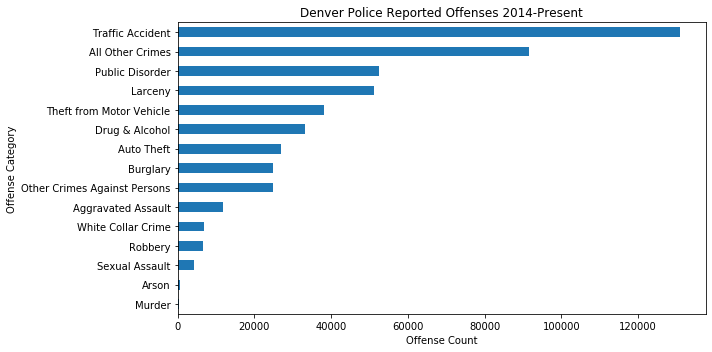

In [24]:
#graph the total incidents by their category name
plt.figure(figsize=(10,5))
df.OFFENSE_CATEGORY_NAME.value_counts().plot(kind='barh', legend=False)
plt.ylabel('Offense Category')
plt.xlabel('Offense Count')
plt.title('Denver Police Reported Offenses 2014-Present')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Thoughts/Comments
- Traffic Accidents are by and large the primary offense reported
- All Other Crimes (an aggregation of many other not as clearly defined offense types) has an immense number of counts - perhaps these could be better categorized?
- Looks like non-violent crime offenses (larceny, theft, burglary, etc.) are much more common than violent crime offenses (aggravated assault, robbery, sexual assault, murder)
- What exactly is public disorder - what types of offenses are these?
- What does just violent crime look like?

#### Traffic Accidents - should they be included?
Traffic accidents in and of themselves are not a crime, but we can observe that the police are generally involved with reported traffic incidents more than any category of crime. For the purposes of this report and for further data analysis, traffic accident data will not be included. But we can look into the data and gain some quick knowledge.

In [25]:
t_df = df[df.OFFENSE_CATEGORY_NAME == 'Traffic Accident']

In [26]:
len(t_df[t_df.IS_CRIME == True])

0

Traffic accidents themselves are never crimes as we can see from the above value.

In [27]:
hit_run_per = len(t_df[t_df.OFFENSE_TYPE_NAME == 'Traffic accident - hit and run']) / len(t_df)

In [28]:
print('Out of all the traffic accidents reported to police, {}% were hit and runs.'.format(round(hit_run_per*100, ndigits=2)))

Out of all the traffic accidents reported to police, 27.14% were hit and runs.


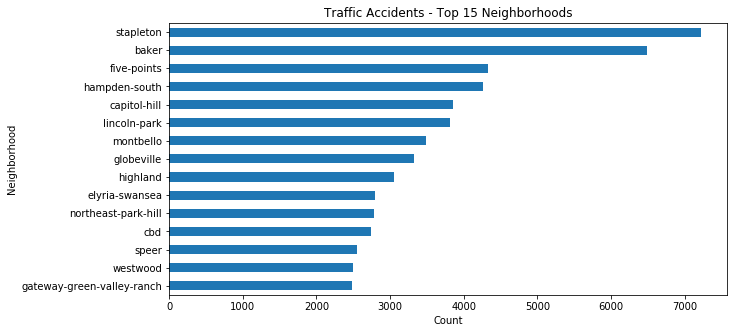

In [29]:
plt.figure(figsize=(10,5))
t_df.NEIGHBORHOOD_ID.value_counts().nlargest(15).plot.barh()
plt.title('Traffic Accidents - Top 15 Neighborhoods')
plt.xlabel('Count')
plt.ylabel('Neighborhood')
plt.gca().invert_yaxis()
plt.show()

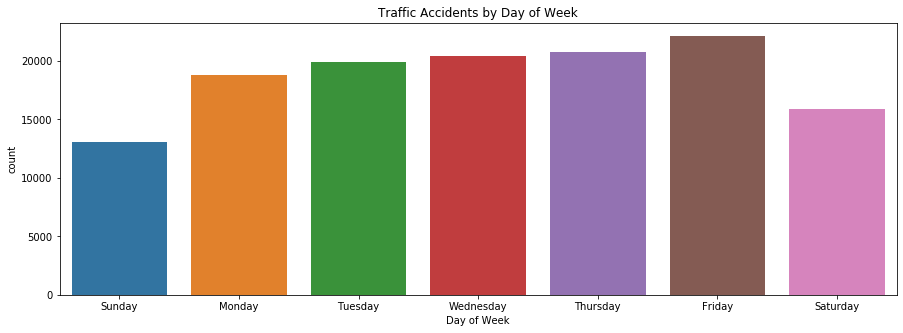

In [30]:
plt.figure(figsize=(15,5))
sns.countplot(data=t_df, x='FIRST_OCCURRENCE_DATE_DOW_N')
plt.title('Traffic Accidents by Day of Week')
plt.xlabel('Day of Week')
plt.show()

Unsurprisingly, Saturday and Sunday have the least number of accidents reported. It appears the number of accidents reported for the workweek actually increases slightly as the week goes on.

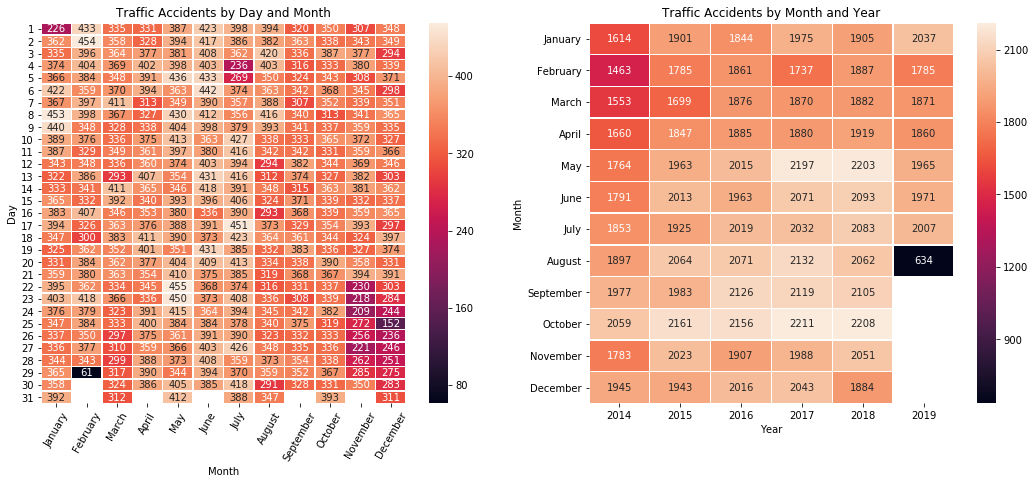

In [31]:
p_d_m = t_df.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_D', 'FIRST_OCCURRENCE_DATE_M_N', aggfunc='count')
p_m_y = t_df.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_M_N', 'FIRST_OCCURRENCE_DATE_Y', aggfunc='count')

plt.figure(figsize=(18,7))

plt.subplot(121)
ax = sns.heatmap(p_d_m, annot=True, linewidths=.5, fmt='.0f')
ax.set_ylim(31, 0)
plt.xticks(rotation=60)
plt.ylabel('Day')
plt.xlabel('Month')
plt.title('Traffic Accidents by Day and Month')

plt.subplot(122)
ax = sns.heatmap(p_m_y, annot=True, linewidths=.5, fmt='.0f')
ax.set_ylim(12, 0)
plt.ylabel('Month')
plt.xlabel('Year')
plt.title('Traffic Accidents by Month and Year')

plt.show()

Takeaways:
- Contrary to what we may think, July 4th/5th actually have many less accidents reported than the apparent norm
- It seems that Thanksgiving and Christmas weeks have an immense effect on the amount of accidents reported (likely because less people are driving on the roads)

*Note: Jan 1, 2014 is not included in this data, and as you can see from the chart on the right, the data may not be complete for the current year (meaning any months we are in or have yet to reach for the year are under counted on the left chart)*

#### What's the deal with All Other Crimes?

In [32]:
aoc = df[df.OFFENSE_CATEGORY_NAME == 'All Other Crimes']

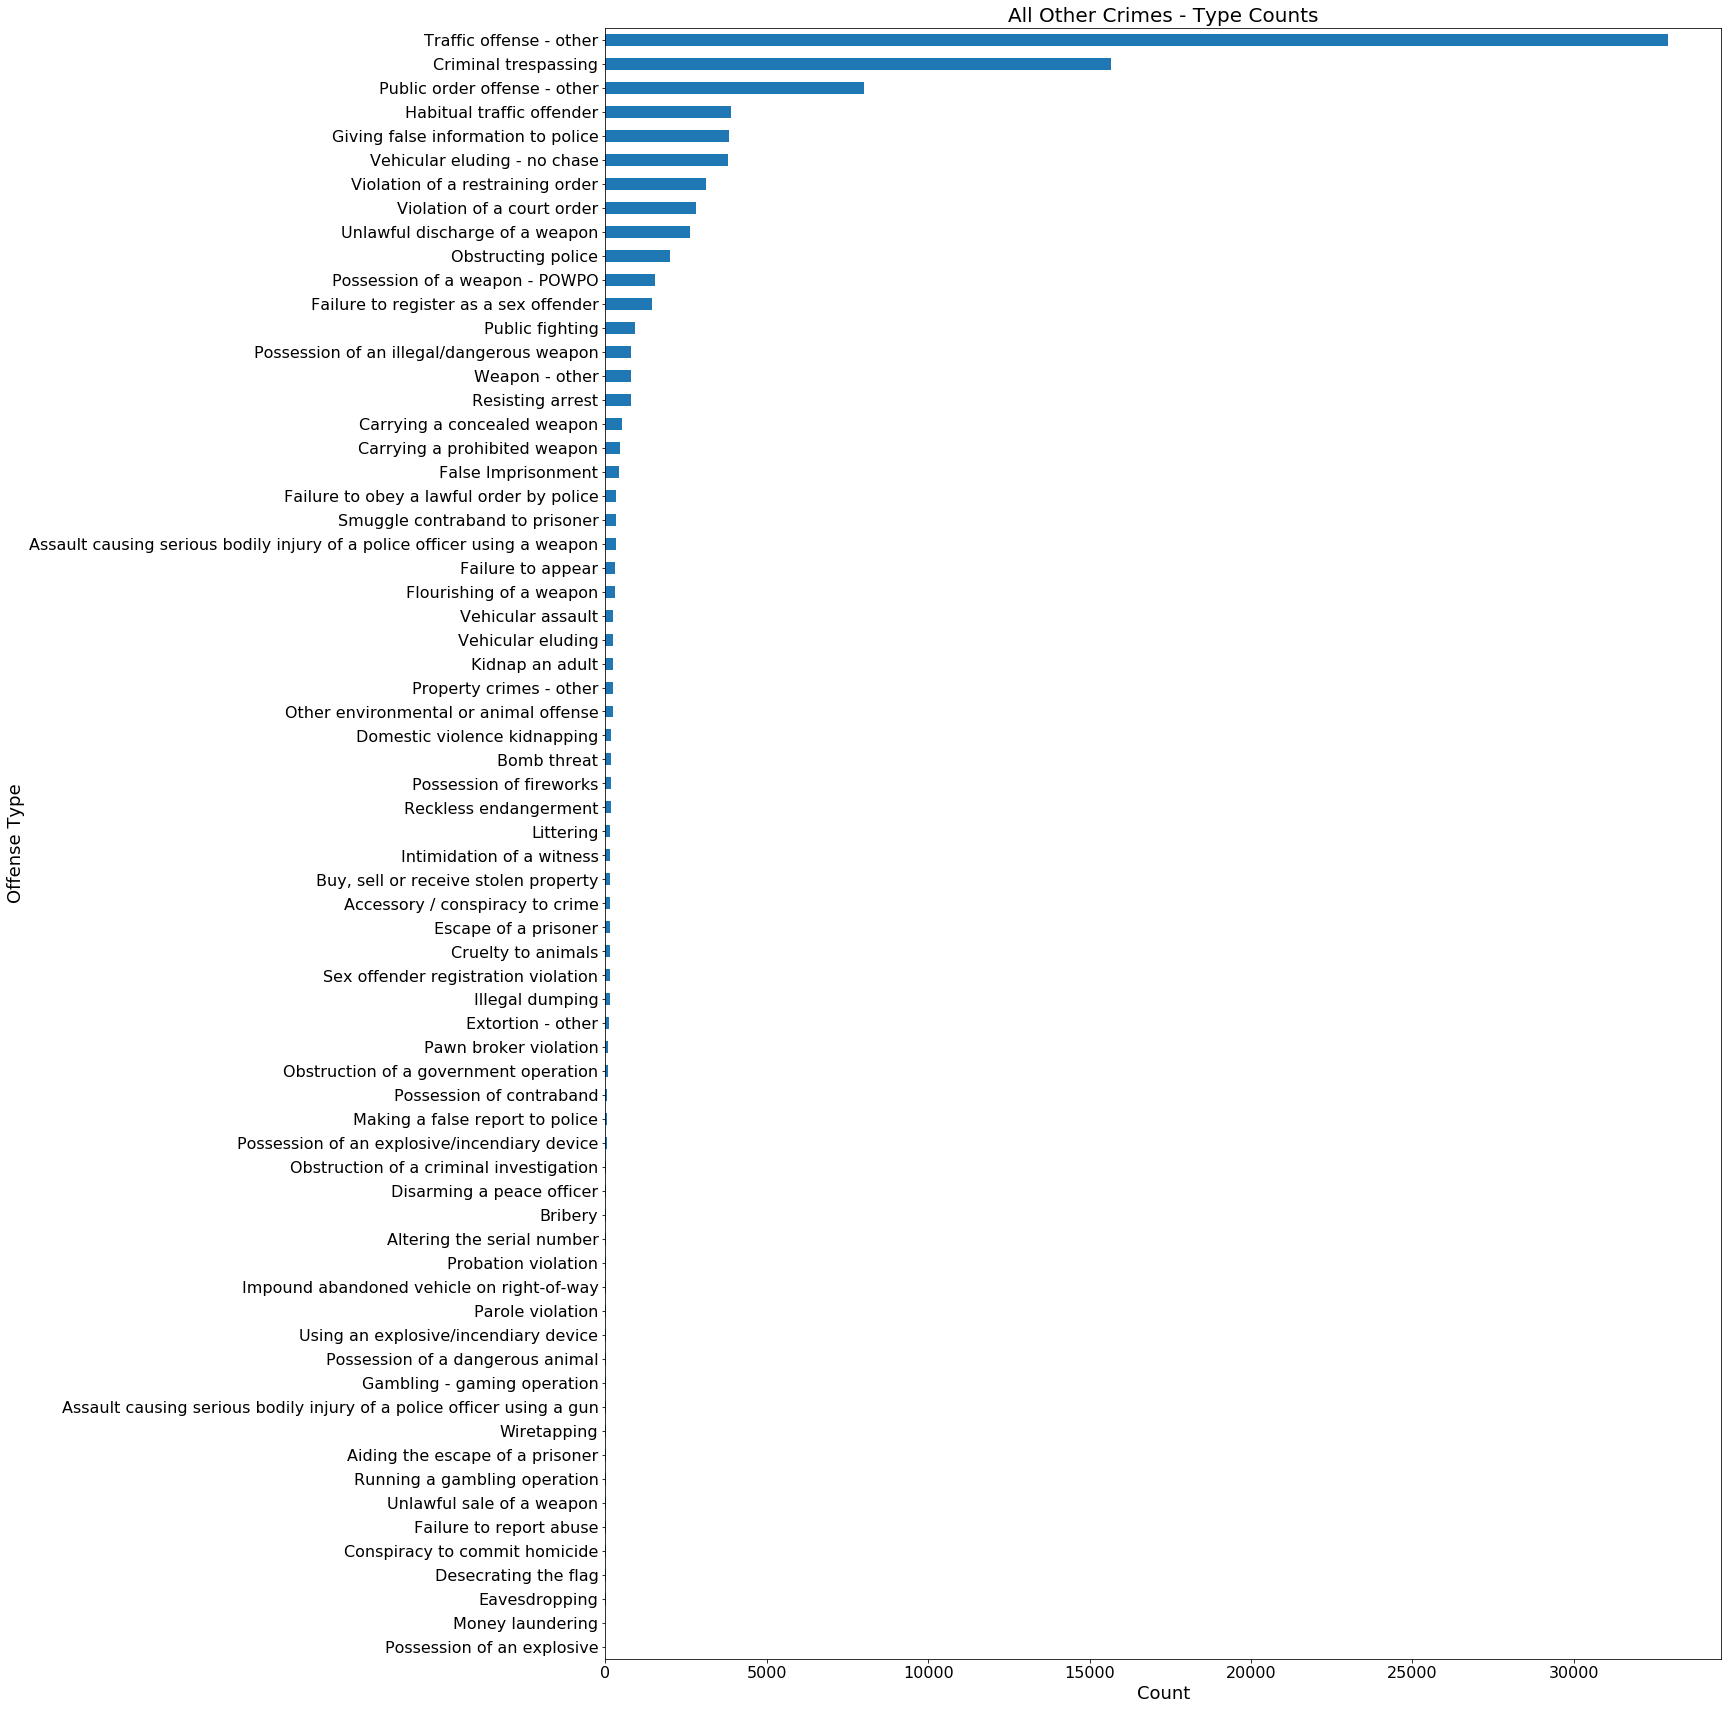

In [33]:
plt.figure(figsize=(20,30))
ax = aoc.OFFENSE_TYPE_NAME.value_counts().plot.barh()
plt.title('All Other Crimes - Type Counts', fontsize=20)
plt.ylabel('Offense Type', fontsize=18)
plt.xlabel('Count', fontsize=18)
ax.tick_params(axis='both', which='both', labelsize=16)
plt.gca().invert_yaxis()
plt.show()

In [34]:
i = aoc.OFFENSE_TYPE_NAME.value_counts()[0]
count = 0
for val in aoc.OFFENSE_TYPE_NAME.value_counts().values[1:]:
    while i > 0:
        i -= val
        count+=1

In [35]:
traf_per = aoc.OFFENSE_TYPE_NAME.value_counts()[0] / aoc.OFFENSE_TYPE_NAME.value_counts().sum()

In [36]:
print('- From the above, it can be observed that there are {} different types of crime in this one category!'.format(len(aoc.OFFENSE_TYPE_NAME.unique())))
print('- "Traffic offense - other" has more occurrences than the next {} types combined!'.format(count))
print('- "Traffic offense - other" also takes up a whopping {}% of this entire category'.format(round(traf_per*100, ndigits=2)))

- From the above, it can be observed that there are 68 different types of crime in this one category!
- "Traffic offense - other" has more occurrences than the next 3 types combined!
- "Traffic offense - other" also takes up a whopping 35.99% of this entire category


In [37]:
len(aoc[(aoc.OFFENSE_TYPE_NAME == 'Traffic offense - other') & (aoc.IS_CRIME == False)])

0

Once again, traffic leads the way. However, these traffic offenses are criminal, from the data provided there is no further specification for what type of traffic offenses are being commited, but there are still a large number of them.

#### Public Disorder - another high volume crime category

In [38]:
pdis = df[df.OFFENSE_CATEGORY_NAME == 'Public Disorder']

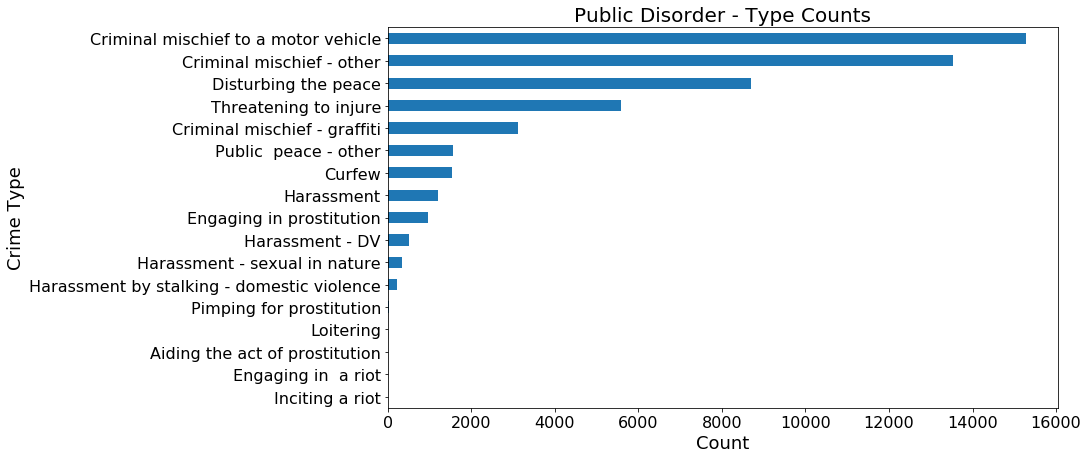

In [39]:
plt.figure(figsize=(12, 7))
ax = pdis.OFFENSE_TYPE_NAME.value_counts().plot.barh()
ax.tick_params(axis='both', which='both', labelsize=16)
plt.title('Public Disorder - Type Counts', fontsize=20)
plt.ylabel('Crime Type', fontsize=18)
plt.xlabel('Count', fontsize=18)
plt.gca().invert_yaxis()

plt.show()

Once again, our highest occurrence type has to do with vehicles. This category is primarily concerned with vandalism, criminal mischief, and what may be considered "crimes against society".

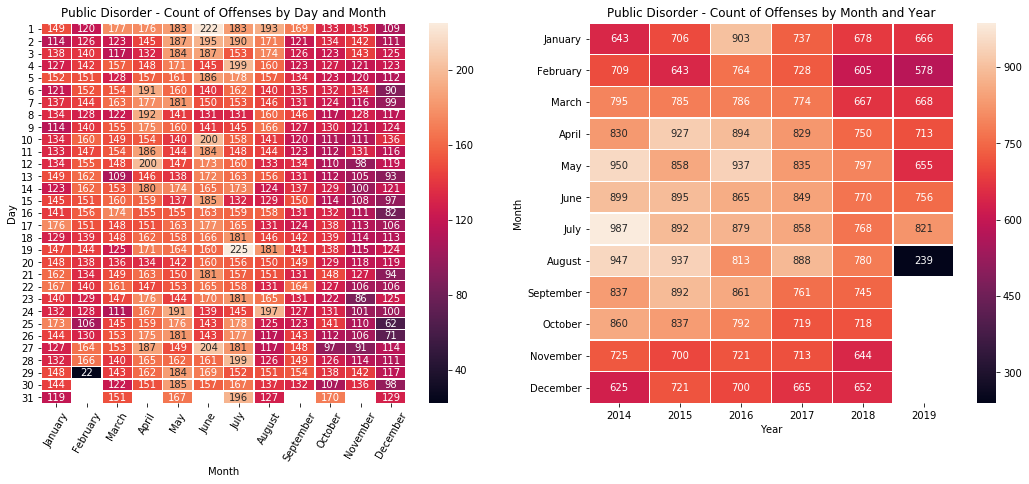

In [40]:
pdis_D_M = pdis.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_D', 'FIRST_OCCURRENCE_DATE_M_N', aggfunc='count')
pdis_M_Y = pdis.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_M_N', 'FIRST_OCCURRENCE_DATE_Y' , aggfunc='count')

plt.figure(figsize=(18,7))

plt.subplot(121)
ax = sns.heatmap(pdis_D_M, annot=True, fmt='.0f', linewidths=.5)
ax.set_ylim(31, 0)
plt.xticks(rotation=60)
plt.title('Public Disorder - Count of Offenses by Day and Month')
plt.xlabel('Month')
plt.ylabel('Day')

plt.subplot(122)
ax = sns.heatmap(pdis_M_Y, annot=True, fmt='.0f', linewidths=.5)
ax.set_ylim(12, 0)
plt.title('Public Disorder - Count of Offenses by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')

plt.show()

Based on a cursory analysis of the heatmaps above - the main observation that can be gleaned is that crimes of the Public Disorder category appear to be slightly more likely to occur in non-winter months.

#### Violent crime - what is it and what are its general characteristics?
In the FBI’s Uniform Crime Reporting (UCR) Program, violent crime is composed of four offenses:  murder and nonnegligent manslaughter, forcible rape, robbery, and aggravated assault. Violent crimes are defined in the UCR Program as those offenses which involve force or threat of force. [[source]](https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/violent-crime)

Based on the above definiton it is easy to assemble a DataFrame consisting of only violent crime offenses.

In [41]:
murder = df[df.OFFENSE_CATEGORY_NAME == 'Murder']
rape = df[df.OFFENSE_CATEGORY_NAME == 'Sexual Assault']
robbery = df[df.OFFENSE_CATEGORY_NAME == 'Robbery']
assault = df[df.OFFENSE_CATEGORY_NAME == 'Aggravated Assault']
v_df = pd.concat([murder, rape, robbery, assault])

Create some pivot tables containing time related data.

In [42]:
v_month = v_df.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_M_N', 'OFFENSE_CATEGORY_NAME', aggfunc='count')
v_dow = v_df.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_DOW_N', 'OFFENSE_CATEGORY_NAME', aggfunc='count')
v_year = v_df.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_Y', 'OFFENSE_CATEGORY_NAME', aggfunc='count')

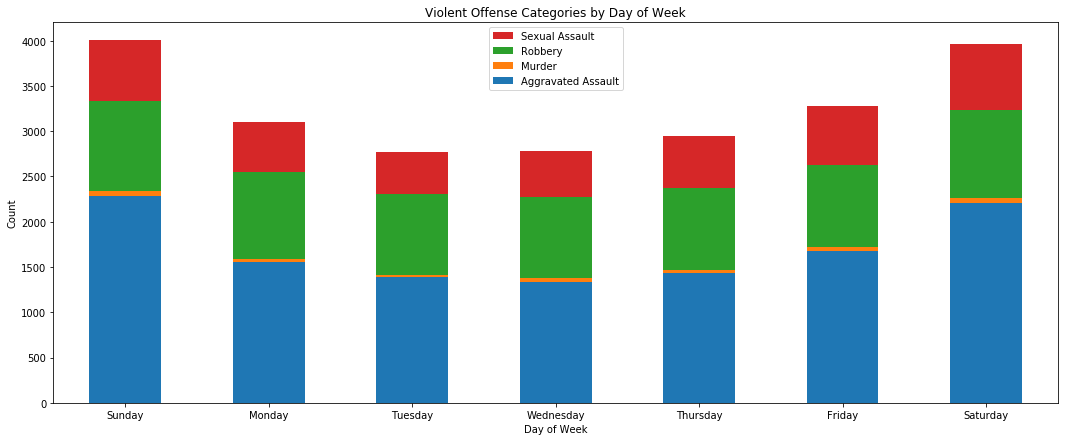

In [43]:
ax = v_dow.plot(kind='bar', figsize=(18,7), stacked=True)
plt.title('Violent Offense Categories by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=0)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[2], handles[1], handles[0]]
labels = [labels[3], labels[2], labels[1], labels[0]]
ax.legend(handles, labels)
plt.show()

- Aggravated Assualt has the biggest effect on violent crime changes throughout the week (much more likely on the weekends)
- Robbery remains relatively consistent throughout the week and also contributes a significant sum to the total
- Sexual Assault is less common that Aggravated Assault, but it appears to have a similar 'weekend more likely' relationship
- The murder count appears to be mostly negligable compared to the amount of other violent crimes

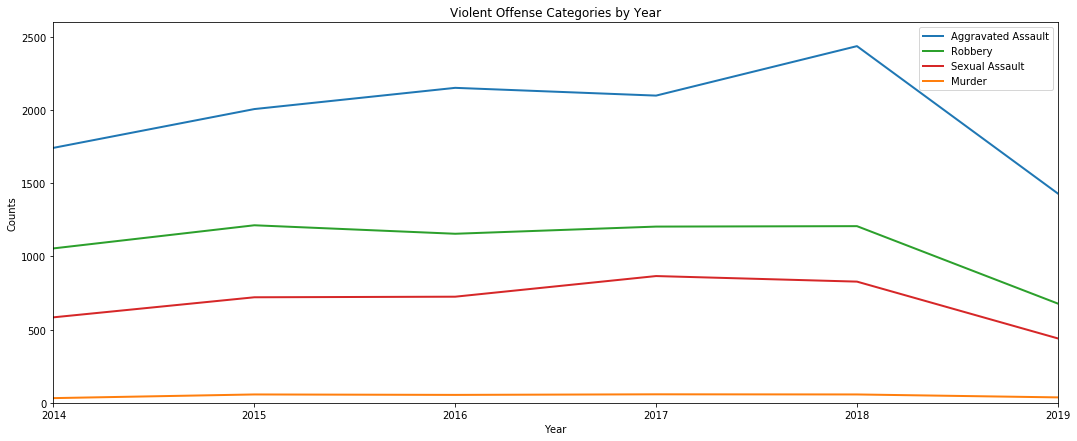

In [44]:
ax = v_year.plot(figsize=(18,7), linewidth=2)
plt.title('Violent Offense Categories by Year')
plt.ylabel('Counts')
plt.xlabel('Year')
plt.ylim(0,2600)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[2], handles[3], handles[1]]
labels = [labels[0], labels[2], labels[3], labels[1]]
ax.legend(handles, labels)
plt.show()

- Appears the amount of violent crime per year is relatively steady (discounting 2019 as it is not yet complete)
- Aggravated Assault had a large uptick in 2018

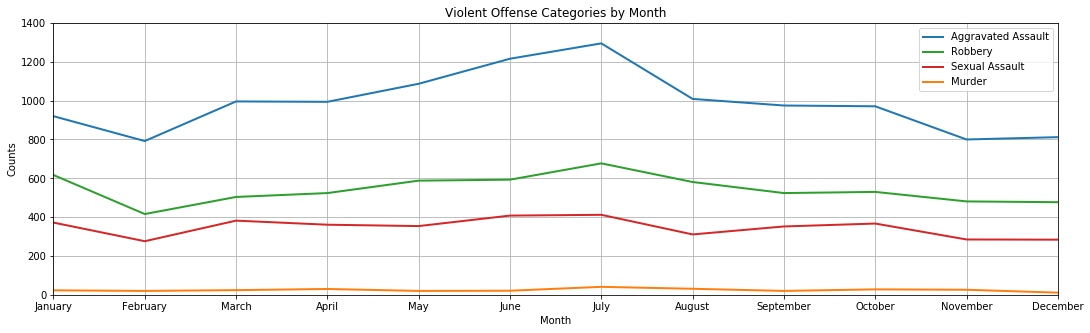

In [45]:
ax = v_month.plot(figsize=(18,5), linewidth=2)
plt.title('Violent Offense Categories by Month')
plt.ylabel('Counts')
plt.xlabel('Month')
plt.xticks(range(len(v_month.index)), v_month.index)
ax.xaxis.grid()
ax.yaxis.grid()
plt.ylim(0, 1400)
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[2], handles[3], handles[1]]
labels = [labels[0], labels[2], labels[3], labels[1]]
ax.legend(handles, labels)
plt.show()

For everything except Murder:
- Violent crime drops in February from January
- Slowly rises to its peak in July
- Starts to drop off beginning in August, decreasing through December
- Jumps back up in January again

#### A Closer Inspection of Murder

In [46]:
m_month = murder.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_M_N', 'OFFENSE_CATEGORY_NAME', aggfunc='count')
m_dow = murder.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_DOW_N', 'OFFENSE_CATEGORY_NAME', aggfunc='count')
m_year = murder.pivot_table('OFFENSE_ID', 'FIRST_OCCURRENCE_DATE_Y', 'OFFENSE_CATEGORY_NAME', aggfunc='count')

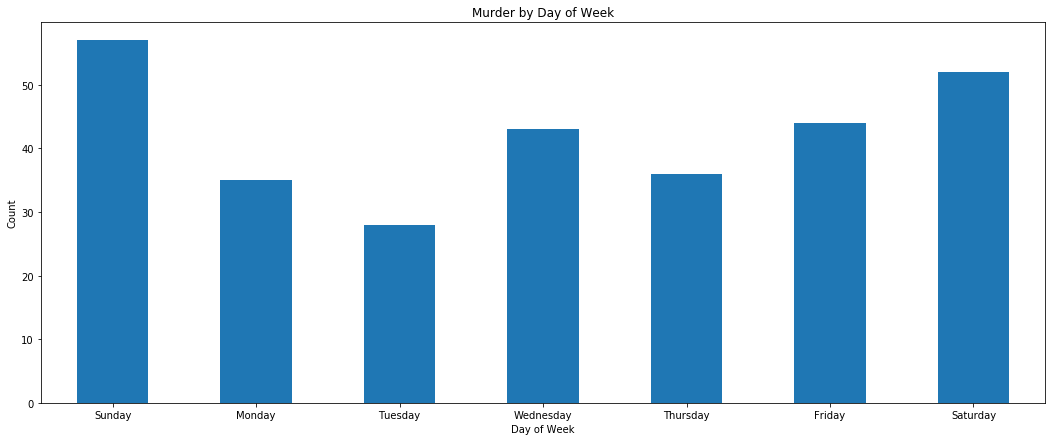

In [47]:
m_dow.plot(kind='bar', figsize=(18,7), legend=False)
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.xlabel('Day of Week')
plt.title('Murder by Day of Week')
plt.show()

- Murder has more cases on Saturday and Sunday, similar to Aggravated Assault and Sexual Assault
- Murder is also higher on Wednesday and Friday on the weekdays

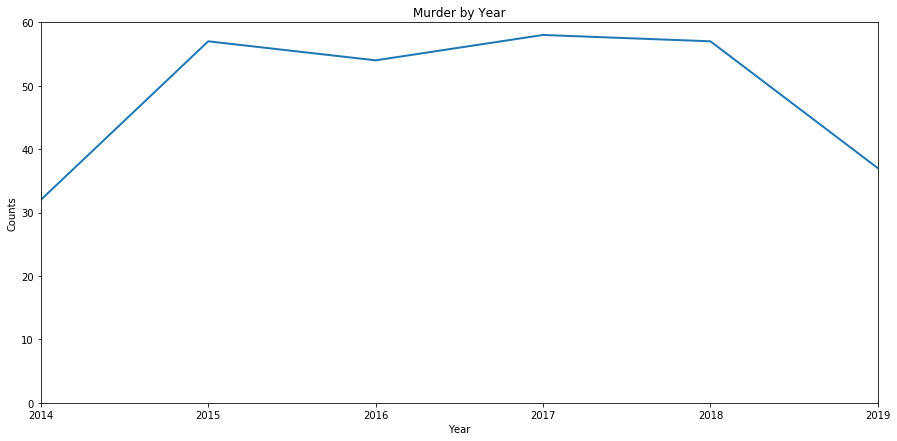

In [48]:
m_year.plot(figsize=(15,7), linewidth=2, legend=False)
plt.title('Murder by Year')
plt.ylabel('Counts')
plt.xlabel('Year')
plt.ylim(0,60)
plt.show()

- 2014 looks like an anomoly year compared to 2015-2018
- Will 2019 remain low?

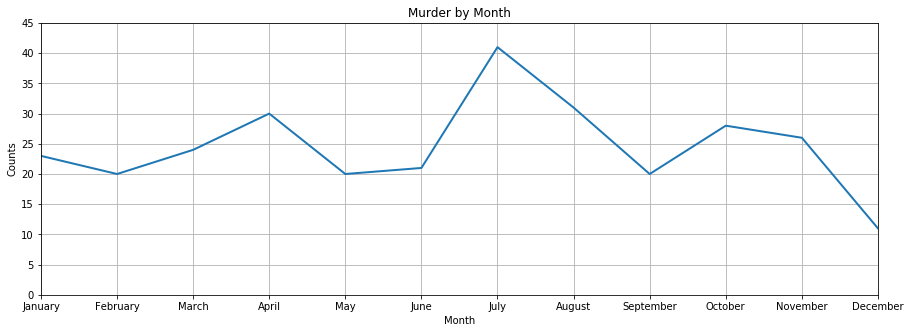

In [49]:
ax = m_month.plot(figsize=(15,5), linewidth=2, legend=False)
plt.title('Murder by Month')
plt.ylabel('Counts')
plt.xlabel('Month')
plt.xticks(range(len(m_month.index)), m_month.index)
plt.ylim(0,45)
ax.xaxis.grid()
ax.yaxis.grid()
plt.show()

- Murder is mostly consistent
- Above average number in July
- Very few cases in December

*Note: YTD is only included up to 30 days prior to the latest incident occurrence (some counts could be inflated/deflated)*

## Section 2: Analytic Questions
1. Does summer have an effect on the violent crime rate?
2. Which neighborhoods are the most dangerous? Are the top 10 most criminal neighborhoods really more dangerous than anywhere else?
3. Do certain types of crime have a report-delay?

### 1. Does summer have an effect on the violent crime rate?

The data used will be from `v_df`, which contains all the violent crimes over the past 5 years in Denver. To answer this question, the proper rate at which to compare summer to everything else needs to be considered. It could be possible to go by month, however summer is not constrained by a monthly parameter, it is constrained to particular days in a year. So likely the best way to separate and compare these two sets of data would be by days of year that occur in summer for a particular year (summer occurs in a different day of year range each year) against those days which occur outside the range of summer.

#### Step 1: Seperating `v_df` into two DataFrames - one with summer offenses and one without

First, we need to find when summer actually occurred each year, this isn't too hard with a quick search on Google.

In [50]:
s2014_start = pd.to_datetime('June 21, 2014')
s2014_end = pd.to_datetime('September 22, 2014')
s2015_start = pd.to_datetime('June 21, 2015')
s2015_end = pd.to_datetime('September 23, 2015')
s2016_start = pd.to_datetime('June 20, 2016')
s2016_end = pd.to_datetime('September 22, 2016')
s2017_start = pd.to_datetime('June 20, 2017')
s2017_end = pd.to_datetime('September 22, 2017')
s2018_start = pd.to_datetime('June 21, 2018')
s2018_end = pd.to_datetime('September 22, 2018')
s2019_start = pd.to_datetime('June 21, 2019')
s2019_end = pd.to_datetime('September 23, 2019')

Filter `v_df` to get only summer offenses.

In [51]:
def f_occ():
    return v_df.FIRST_OCCURRENCE_DATE

Create a summer filter.

In [52]:
s2014 = ((s2014_start < f_occ()) & (f_occ() < s2014_end))
s2015 = ((s2015_start < f_occ()) & (f_occ() < s2015_end))
s2016 = ((s2016_start < f_occ()) & (f_occ() < s2016_end))
s2017 = ((s2017_start < f_occ()) & (f_occ() < s2017_end))
s2018 = ((s2018_start < f_occ()) & (f_occ() < s2018_end))
s2019 = ((s2019_start < f_occ()) & (f_occ() < s2019_end))
sfilt = s2014 | s2015 | s2016 | s2017 | s2018 | s2019

Use filter to create new summer violent crime DataFrame, `s_v_df`.

In [53]:
s_v_df = v_df[sfilt]

Then to get our non-summer values we can just use the inverse of `sfilt`.

In [54]:
ns_v_df = v_df[~sfilt]

Now we need to find our average violent crimes per day for both summer and then for non-summer.

In [55]:
sf_year = s_v_df.FIRST_OCCURRENCE_DATE.dt.year.rename('year')
sf_dayofyear = s_v_df.FIRST_OCCURRENCE_DATE.dt.dayofyear.rename('dayofyear')

In [56]:
s_counts = s_v_df.groupby([sf_year, sf_dayofyear]).count().INCIDENT_ID

In [57]:
md('`%f` is the average number of violent crimes per day in Denver during summer. The non-summer mean can be found similarly.'%(s_counts.mean()))

`12.466281` is the average number of violent crimes per day in Denver during summer. The non-summer mean can be found similarly.

In [58]:
nsf_year = ns_v_df.FIRST_OCCURRENCE_DATE.dt.year.rename('year')
nsf_dayofyear = ns_v_df.FIRST_OCCURRENCE_DATE.dt.dayofyear.rename('dayofyear')
ns_counts = ns_v_df.groupby([nsf_year, nsf_dayofyear]).count().INCIDENT_ID
ns_counts.mean()

10.684073107049608

#### Step 2: Checking Normality

In [59]:
s_mu, s_std = stats.norm.fit(s_counts)
ns_mu, ns_std = stats.norm.fit(ns_counts)

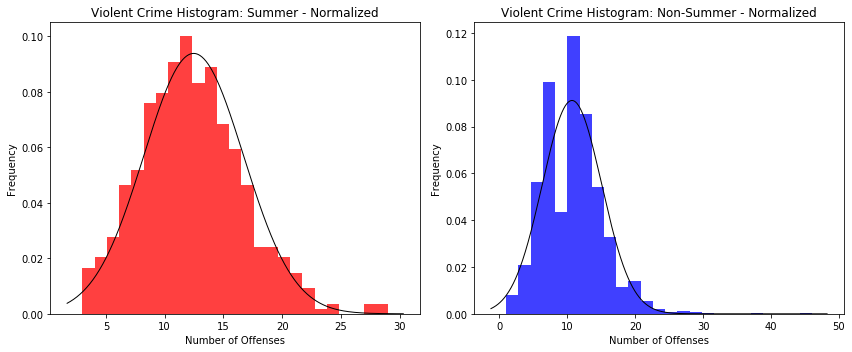

In [60]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(s_counts, bins=25, density=True, color='red', alpha=.75)
plt.title('Violent Crime Histogram: Summer - Normalized')
plt.ylabel('Frequency')
plt.xlabel('Number of Offenses')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, len(s_counts))
p = stats.norm.pdf(x, s_mu, s_std)
plt.plot(x, p, 'k', linewidth=1)
plt.subplot(122)
plt.title('Violent Crime Histogram: Non-Summer - Normalized')
plt.hist(ns_counts, bins=25, density=True, color='blue', alpha=.75)
plt.ylabel('Frequency')
plt.xlabel('Number of Offenses')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, len(ns_counts))
p = stats.norm.pdf(x, ns_mu, ns_std)
plt.plot(x, p, 'k', linewidth=1)

plt.tight_layout()
plt.show()

Based on a quick view of the histograms, it appears that both summer and non-summer crime are approximately normal. Probability plots are another good way to check.

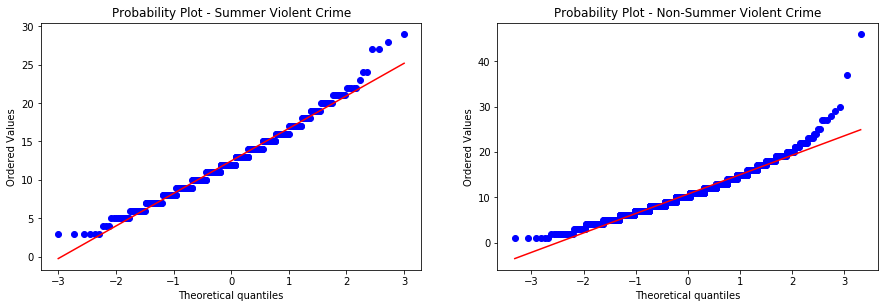

In [61]:
plt.figure(figsize=(15,10))

plt.subplot(221)
stats.probplot(s_counts, dist='norm', plot=plt)
plt.title('Probability Plot - Summer Violent Crime')

plt.subplot(222)
stats.probplot(ns_counts, dist='norm', plot=plt)
plt.title('Probability Plot - Non-Summer Violent Crime')

plt.show()

These look normally distributed to a point, the extremes or outliers seem to skew the data a bit, most of our data appears like-normal for both summer and non-summer datasets. Let's do one last look at the skew and kurtosis to see how they look.

In [62]:
print('Summer Skew: {} | Summer Kurtosis: {}'.format(s_counts.skew(), s_counts.kurt()))
print('Non-summer Skew: {} | Non-summer Kurtosis: {}'.format(ns_counts.skew(), ns_counts.kurt()))

Summer Skew: 0.46238788471284564 | Summer Kurtosis: 0.6044885977243415
Non-summer Skew: 1.0149892394835813 | Non-summer Kurtosis: 3.987307943827443


The summer data's skew is is slightly positive, but still very close to zero, this indicates that our data trails off more in the positive direction than a normal distribution. The non-summer data's skew is similar, but almost double, which indicates that the outliers are more positively skewed (meaning we either have a few very large outliers or many small ones). The Kurtosis (rather "excess kurtosis" in this case) indicates that the tails of our distributions' are 'heavy' or that more values fall within the relative tails compared to the normal distribution. These values in and of themselves aren't necessarily useful in determining how normal our data is, but rather tells us in what ways it is not normal.

#### Step 3: The Tests
1. T-test in the case of normality
2. Mann-Whitney U Test in case the data is not normal

For both tests we must have a null hypothesis and an alternative hypothesis - which happen to be the same in this case.
- Null Hypothesis: Summer has no effect on the violent crime rate
- Alternative Hypothesis: Summer does have an effect on the violent crime rate

To test our null hypothesis the two populations `s_v_df` and `ns_v_df` must be compared, in other words the null hypothesis is asking if the sample `s_v_df` and `ns_v_df` come from the same population. If not, then the null hypothesis is rejected and the inference that summer has an effect on violent crime can be made.

In [63]:
t_stat, t_pval = stats.ttest_ind(s_counts, ns_counts, equal_var=False)
u_stat, u_pval = stats.mannwhitneyu(s_counts, ns_counts, alternative='two-sided')

In [64]:
md('The T-test statistic is %f with a p-value of %s'%(t_stat, str(t_pval)))

The T-test statistic is 8.187292 with a p-value of 8.906492937971397e-16

In [65]:
md('The Mann-Whitney U statistic is %f with a p-value of %s'%(u_stat, str(u_pval)))

The Mann-Whitney U statistic is 497514.000000 with a p-value of 8.246232614505925e-18

#### Conclusion: Does summer have an effect on the violent crime rate?

- In the case that the data follows a like-normal distribution, the T-test rejects the null hypothesis that summer has no effect on the violent crime rate and instead supports the alternative that summer does have a significant effect on the crime rate in Denver.
- In the case that the data is not normal, the Mann-Whitney U Test also rejects the null hypothesis and supports the conclusion that summer does indeed have an effect on the violent crime rate in Denver.

### 2. Which neighborhoods are the most dangerous? Are the top 10 most criminal neighborhoods statistically more dangerous than anywhere else?

The first question can be answered quite easily, the most dangerous neighborhoods would be those with the most violent crime. So `v_df` can be used to quickly summarize the most dangerous neighborhoods. 

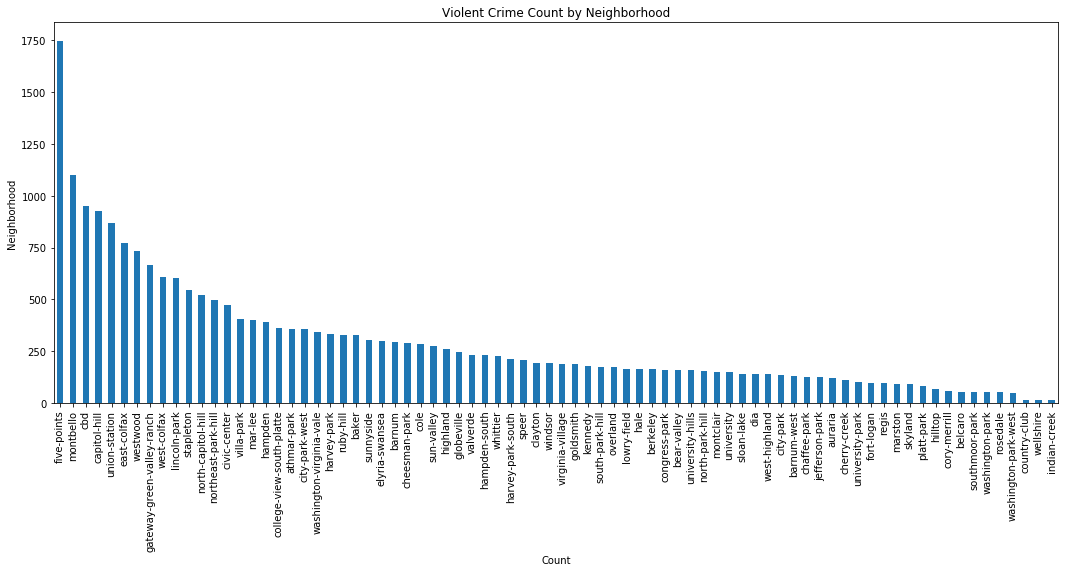

In [66]:
plt.figure(figsize=(18,7))
ax = v_df.NEIGHBORHOOD_ID.value_counts().plot.bar()
plt.title('Violent Crime Count by Neighborhood')
plt.ylabel('Neighborhood')
plt.xlabel('Count')
ax.tick_params(axis='both', which='both', labelsize=10)
plt.show()

- Five Points has a much higher violent crime rate than anywhere else
- There are some neighborhoods where violent crime is very rare (Country Club/Wellshire/Indian Creek)

#### Are the top 10 most criminal neighborhoods statistically more dangerous than anywhere else?
Similar to comparing summer to non-summer, the top 10 most criminal neighborhoods will be compared with the rest. First the two groups must be separated.

In [67]:
top10 = list(v_df.NEIGHBORHOOD_ID.value_counts().index[0:10])
bottom = list(v_df.NEIGHBORHOOD_ID.value_counts().index[10:])

top_df = pd.DataFrame()
for i in top10:
    top_df = top_df.append(v_df[v_df.NEIGHBORHOOD_ID == i])
    
bot_df = pd.DataFrame()
for i in bottom:
    bot_df = bot_df.append(v_df[v_df.NEIGHBORHOOD_ID == i])

Two dataframes `top_df` and `bot_df` have been created to represent the two populations. The average crime per day per neighborhood can now be calculated for these location groups.

In [137]:
top_year = top_df.FIRST_OCCURRENCE_DATE.dt.year.rename('year')
top_dayofyear = top_df.FIRST_OCCURRENCE_DATE.dt.dayofyear.rename('dayofyear')
top_counts = s_v_df.groupby(['NEIGHBORHOOD_ID', top_year, top_dayofyear]).count().OFFENSE_ID
bot_year = bot_df.FIRST_OCCURRENCE_DATE.dt.year.rename('year')
bot_dayofyear = bot_df.FIRST_OCCURRENCE_DATE.dt.dayofyear.rename('dayofyear')
bot_counts = bot_df.groupby(['NEIGHBORHOOD_ID', bot_year, bot_dayofyear]).count().OFFENSE_ID

In [146]:
top_counts.mean()

1.3394160583941606

In [147]:
bot_counts.mean()

1.095268188640493

#### Checking for Normality

In [154]:
top_mu, top_std = stats.norm.fit(top_counts)
bot_mu, bot_std = stats.norm.fit(bot_counts)

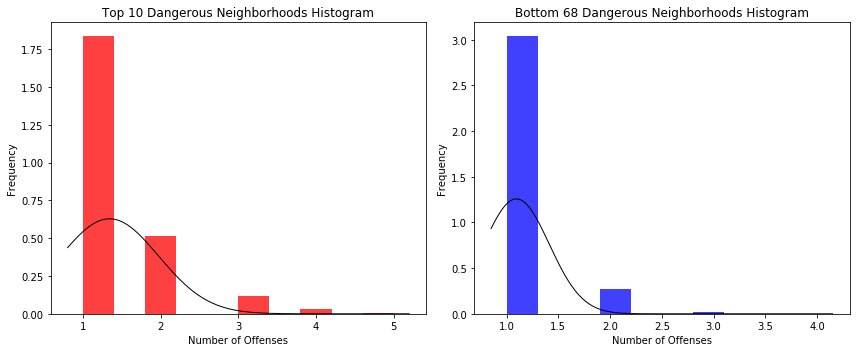

In [156]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(top_counts, bins=10, density=True, color='red', alpha=.75)
plt.title('Top 10 Dangerous Neighborhoods Histogram')
plt.ylabel('Frequency')
plt.xlabel('Number of Offenses')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, len(top_counts))
p = stats.norm.pdf(x, top_mu, top_std)
plt.plot(x, p, 'k', linewidth=1)
plt.subplot(122)
plt.title('Bottom 68 Dangerous Neighborhoods Histogram')
plt.hist(bot_counts, bins=10, density=True, color='blue', alpha=.75)
plt.ylabel('Frequency')
plt.xlabel('Number of Offenses')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, len(bot_counts))
p = stats.norm.pdf(x, bot_mu, bot_std)
plt.plot(x, p, 'k', linewidth=1)

plt.tight_layout()
plt.show()

Based on a quick view of the histograms, these two variables do not appear to be normal.

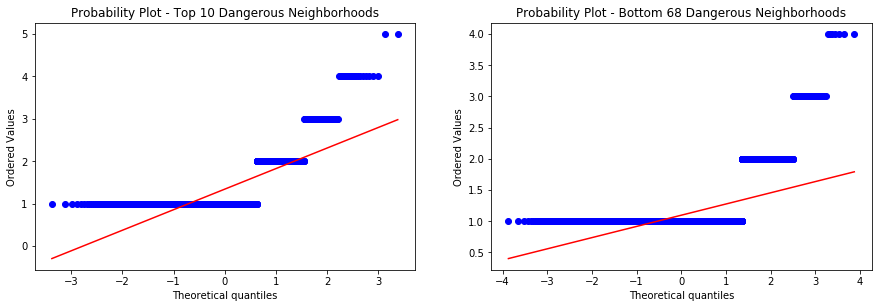

In [157]:
plt.figure(figsize=(15,10))

plt.subplot(221)
stats.probplot(top_counts, dist='norm', plot=plt)
plt.title('Probability Plot - Top 10 Dangerous Neighborhoods')

plt.subplot(222)
stats.probplot(bot_counts, dist='norm', plot=plt)
plt.title('Probability Plot - Bottom 68 Dangerous Neighborhoods')

plt.show()

These don't even look close to being normal. There is no point to check skew and kurtosis as they are going to be wildly away from 0.

#### Testing
- Use non-paramentric Mann-Whitney U Test

There must be a null hypothesis and an alternative hypothesis:
- Null Hypothesis: The two sample groups `top_counts` and `bot_counts` come from the same population - top 10 dangerous neighborhoods are not significantly different than the rest of the neighborhoods
- Alternative Hypothesis: The aforementioned sample groups do not come from the same population - thus there is a significant difference between the top 10 neighborhoods' violent crime rate and the rest of the neighborhoods

To test our null hypothesis the two populations `top_df` and `bot_df` must be compared.

In [159]:
u_stat, u_pval = stats.mannwhitneyu(top_counts, bot_counts, alternative='two-sided')

In [160]:
md('The Mann-Whitney U statistic is %f with a p-value of %s'%(u_stat, str(u_pval)))

The Mann-Whitney U statistic is 14331184.000000 with a p-value of 1.3649695964729623e-120

#### Conclusion: The Top 10 Neighborhoods are Significantly Different from the Rest

- The Mann-Whitney U Test rejects the null hypothesis and supports the conclusion that the Top 10 Neighborhoods' crime rates are significantly different from the other 68 neighborhoods.

### 3. Are there certain types of crime that take a longer time to report?
For this question the main DataFrame, `df`, will be used. The primary interest here is to see if any of the values under `OFFENSE_TYPE_NAME` tend to have a larger `DATE_DIFF` - the difference between when the incident occurred and when it was reported.

In [181]:
report_df = df.loc[:, ['OFFENSE_ID','OFFENSE_CATEGORY_NAME', 'OFFENSE_TYPE_NAME', 'DATE_DIFF']]

In [182]:
rep_type_df = pd.DataFrame()
rep_cat_df = pd.DataFrame()

In [183]:
for val in report_df.OFFENSE_TYPE_NAME.unique():
    rep_type_df.loc[val, 'DIFF_MEAN'] = report_df[report_type_df.OFFENSE_TYPE_NAME == val].DATE_DIFF.mean()
for val in report_df.OFFENSE_CATEGORY_NAME.unique():
    rep_cat_df.loc[val, 'DIFF_MEAN'] = report_df[report_cat_df.OFFENSE_CATEGORY_NAME == val].DATE_DIFF.mean()

In [185]:
for i in rep_cat_df.index:
    rep_cat_df.loc[i, 'DIFF_MEAN'] = rep_cat_df.loc[i, 'DIFF_MEAN'].seconds/(3600) + rep_cat_df.loc[i, 'DIFF_MEAN'].days*24
for i in rep_type_df.index:
    rep_type_df.loc[i, 'DIFF_MEAN'] = rep_type_df.loc[i, 'DIFF_MEAN'].seconds/(3600) +rep_type_df.loc[i, 'DIFF_MEAN'].days*24

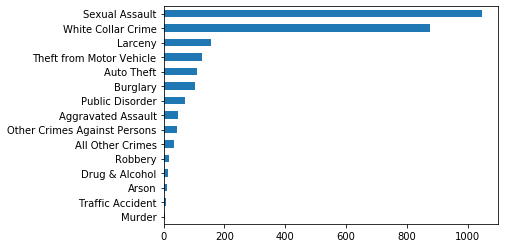

In [194]:
rep_cat_df.DIFF_MEAN.sort_values(ascending=True).plot(kind='barh')